<a href="https://colab.research.google.com/github/jincy-p-janardhanan/Text-Clustering/blob/main/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

In [ ]:
! pip install contractions
! pip install autocorrect
! pip install pattern

In [2]:
import requests
import nltk
import contractions
import string
import autocorrect
import re
from gensim.utils import lemmatize

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

## Download dataset

In [4]:
def downloadfile(url, path):
  r = requests.get(url, stream=True)
  with open(path, "wb") as f:
    for block in r.iter_content(chunk_size=1024):
      if block:
        f.write(block)

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00314/%5bUCI%5d%20AAAI-13%20Accepted%20Papers%20-%20Papers.csv'
loc = '/content/'
filename = 'AAAI-accepted-papers-2013.csv'
path = loc+filename
downloadfile(url, path)

## Load Dataset

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(path)
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  150 non-null    object
 1   Keywords               150 non-null    object
 2   Topics                 150 non-null    object
 3   High-Level Keyword(s)  150 non-null    object
 4   Abstract               150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB


# Text Preprocessing

Null value check

In [9]:
missing_values = df.isna().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


Apply various text transformations (on a copy of the dataframe).

In [10]:
df2 = df.copy(deep=True)

# convert to lower case
df2 = df2.apply(lambda x: x.str.lower())

# fix contractions (E.g. it's => it is, I'm => I am, etc.)
df2 = df2.apply(lambda x:[contractions.fix(i) for i in x])

# To make keywords to arrays, first replace [' or ', ' and ', '\n' , '(', ')', '/'] with ' \n '
keywordcols = ['Keywords', 'Topics', 'High-Level Keyword(s)']
df2[keywordcols] = df2[keywordcols].apply(lambda x:[re.sub('( or | and |\\n|\(|\)|\/)', ' \n ', i) for i in x])

# Replace special characters (preserving space and \n) in keyowrd cols
df2[keywordcols] = df2[keywordcols].apply(lambda x: [re.sub('[^a-z0-9 \n]', ' ', i) for i in x])

# Replace special characters (preserving only space) in nonkey cols
nonkeycols = list(set(df2.columns) - set(keywordcols))
df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [re.sub('[^a-z0-9]', ' ', i) for i in x])

# correct any misspelled words before splitting keywords
corrector = autocorrect.Speller()
df2 = df2.apply(lambda x: [corrector(i) for i in x])
df2.head()

# tokenize keywords (for clustering based on keywords)
df2[keywordcols] = df2[keywordcols].apply(lambda x:[[j.strip() for j in i.split('\n')] for i in x])
# fix any empty strings in keyword lists and replace space by '_'
df2[keywordcols] = df2[keywordcols].apply(lambda x: [[('_'.join(j.split())) for j in i if j] for i in x])

# tokenize nonkey columns
df2[nonkeycols] = df2[nonkeycols].apply(lambda x:[nltk.tokenize.word_tokenize(i) for i in x])

# remove stop words from non key columns
df2[nonkeycols] = df2[nonkeycols].apply(
    lambda x: [
               [ w for w in wordlist if w not in nltk.corpus.stopwords.words('english')] 
               for wordlist in x])

Not sure of why this happens, but the `lemmatize()` function works only after a few retries.

In [11]:
# Lemmatize tokens in nonkey cols
for attempt in range(1, 11):
  try:
    print(f'Lemmatize attempt: {attempt}')
    df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [ 
                  [ (l.decode('utf-8')).split('/', 1)[0]
                    for w in wordlist for l in lemmatize(w)]
                  for wordlist in x])
    print(f'Attempt {attempt} success!')
    break
  except:
    pass

Lemmatize attempt: 1
Lemmatize attempt: 2
Lemmatize attempt: 3
Lemmatize attempt: 4
Attempt 4 success!


In [12]:
df2.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,"[cascade, auction, mechanism, determine, collu...","[mediators, auctions, collusion, ad_exchanges]","[auctions, market_based_systems, e_commerce, g...",[multiagent_systems],"[introduce, seal, bid, auction, single, item, ..."
1,"[basis, adaptation, sparse, nonlinear, reinfor...","[reinforcement_learning, varsity, mirror_desce...","[dimension_reduction, feature_selection, onlin...","[machine_learning, reasoning_under_uncertainty]","[paper, present, new, approach, basis, adaptat..."
2,"[optimal, coalition, structure, cooperative, g...","[cooperative_game_theory, coalition_structure_...","[coordination, collaboration, game_theory]",[multiagent_systems],"[representation, language, coalition, game, ke..."
3,"[external, memory, best, first, search, multip...","[external_memory_search, parallel_search, mult...","[heuristic_search, evaluation, analysis, searc...","[heuristic_search, optimization]","[multiple, sequence, alignment, msa, central, ..."
4,"[post, price, exchange, display, advertising, ...","[display_advertising, dynamic_pricing, market_...","[auctions, market_based_systems, e_commerce, m...",[multiagent_systems],"[propose, new, market, design, display, advert..."


In [13]:
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [14]:
df = df2.copy(deep=True)

# Visualization

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

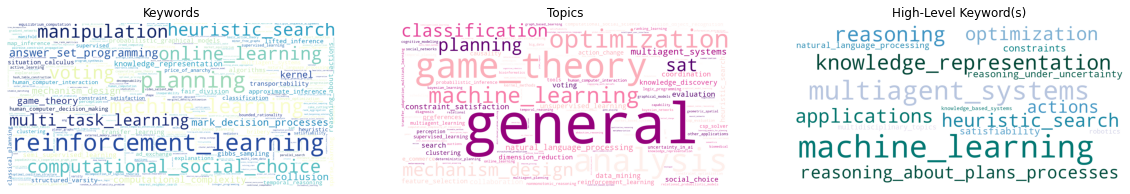

In [16]:
seed = 10
colormaps = ['YlGnBu', 'RdPu', 'PuBuGn']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(keywordcols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[keywordcols[i]] for j in i]))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(keywordcols[i])
plt.show()

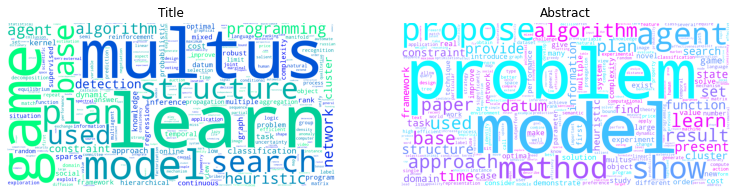

In [17]:
colormaps = ['winter', 'cool']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(nonkeycols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[nonkeycols[i]] for j in i]))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(nonkeycols[i])
plt.show()

# Word Embeddings

In [18]:
# import sklearn
# import numpy as np
# vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features = 5000)
# df['data'] = df.apply(lambda row: (' '.join(' '.join(i) for i in row.values)), axis=1)
# embedding = vectorizer.fit_transform(df['data'])
# embedding = sklearn.preprocessing.normalize(embedding)
# embedding = embedding.toarray()
# vocab_list = vectorizer.get_feature_names_out()
# embed_df = pd.DataFrame(embedding, columns=vocab_list).head()
# embed_df.describe()

In [19]:
from gensim.models import Word2Vec
import multiprocessing

In [20]:
df['datatokens'] = df.apply(lambda row: ' '.join(' '.join(i) for i in row.values).split(), axis=1)
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=4, window=4, size=300, alpha=0.03, min_alpha=0.0007, sg = 1, workers=cores-1)

w2v_model.build_vocab(df['datatokens'], progress_per=10000)
w2v_model.train(df['datatokens'], total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

(1215219, 1650800)

In [21]:
w2v_model.corpus_count

150

In [22]:
w2v_model.wv.most_similar('machine_learning')

[('feature_selection', 0.5777148008346558),
 ('dimension_reduction', 0.5748518109321594),
 ('kernel_methods', 0.5728932619094849),
 ('supervised_learning', 0.5022565126419067),
 ('transfer_adaptation_multitask_learning', 0.4831206798553467),
 ('ranking_learning', 0.47927355766296387),
 ('multi_task_learning', 0.47140344977378845),
 ('structured_prediction', 0.4705660343170166),
 ('knowledge_discovery', 0.4670236110687256),
 ('online_learning', 0.45774972438812256)]

In [23]:
w2v_model.wv.most_similar('learn')

[('active_learning', 0.3881748914718628),
 ('multi_task_learning', 0.37984129786491394),
 ('lifelong', 0.3738686144351959),
 ('reinforcement', 0.35423970222473145),
 ('transfer_adaptation_multitask_learning', 0.3374069333076477),
 ('active', 0.32756170630455017),
 ('retrieval', 0.30866366624832153),
 ('machine', 0.30841147899627686),
 ('dimension_reduction', 0.3058682084083557),
 ('feature_selection', 0.29166048765182495)]

In [24]:
X = w2v_model.wv[w2v_model.wv.vocab]

In [25]:
X.shape

(1037, 300)

# K-Means Clustering

In [26]:
from nltk.cluster import KMeansClusterer
import nltk

In [27]:
NUM_CLUSTERS=10
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[7, 6, 6, 6, 4, 4, 6, 4, 4, 2, 6, 6, 7, 7, 9, 7, 7, 7, 3, 7, 1, 4, 7, 7, 7, 7, 1, 7, 7, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 5, 8, 9, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 8, 2, 2, 5, 2, 2, 2, 9, 2, 4, 2, 5, 2, 2, 9, 0, 5, 2, 8, 0, 1, 9, 0, 9, 0, 0, 8, 2, 8, 9, 6, 0, 4, 2, 6, 4, 4, 0, 1, 4, 4, 6, 6, 1, 3, 6, 6, 1, 2, 1, 1, 1, 2, 3, 2, 6, 6, 2, 6, 2, 0, 7, 5, 9, 7, 8, 2, 7, 6, 5, 6, 2, 7, 7, 1, 1, 9, 9, 5, 0, 5, 4, 4, 4, 4, 4, 9, 6, 0, 2, 2, 1, 2, 1, 1, 1, 1, 5, 7, 7, 7, 1, 5, 1, 5, 5, 8, 4, 1, 4, 5, 7, 8, 8, 8, 1, 5, 2, 8, 8, 5, 5, 3, 9, 9, 3, 7, 7, 9, 9, 7, 2, 8, 0, 5, 7, 7, 7, 6, 7, 9, 1, 2, 1, 9, 0, 8, 8, 5, 2, 0, 9, 4, 4, 4, 2, 8, 0, 9, 3, 9, 2, 0, 8, 8, 1, 8, 8, 8, 8, 8, 0, 1, 0, 0, 8, 3, 0, 3, 0, 1, 1, 6, 1, 3, 7, 7, 3, 3, 7, 0, 4, 0, 4, 7, 0, 0, 0, 2, 0, 3, 0, 8, 0, 8, 0, 8, 6, 4, 5, 4, 4, 4, 4, 1, 3, 6, 7, 7, 9, 1, 7, 9, 5, 9, 5, 7, 7, 0, 5, 6, 1, 2, 1, 0, 7, 7, 6, 4, 6, 6, 6, 4, 6, 7, 7, 7, 3, 1, 7, 6, 7, 1, 3, 2, 7, 7, 3, 8, 2, 3, 2, 4, 4, 7, 8, 8, 6, 